In [2]:
import pandas as pd
import numpy as np
import surprise 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## DATA

In [2]:
class dataModule:
    def __init__(self, test_size : float = 0.2):
        self.x: pd.DataFrame | None = None
        self.y: pd.DataFrame | None = None
        self.train_x: pd.DataFrame | None = None
        self.train_y: pd.DataFrame | None = None
        self.test_x: pd.DataFrame | None = None
        self.test_y: pd.DataFrame | None = None
        self.test_size = test_size
    
    def prepare_data(self) -> tuple[pd.DataFrame]:
        data = surprise.Dataset.load_builtin('ml-100k', prompt=False)
        col_names = ["userid", "itemid", "rating", "timestamp"]
        raw_data = pd.DataFrame(data.raw_ratings, columns=col_names)
        self.x = raw_data.drop(["rating"], axis=1)
        self.y = raw_data.loc[:, "rating"]

        self.split_data()
        return self.train_x, self.test_x, self.train_y, self.test_y

    def split_data(self) -> None:
        user_ids = self.x['userid'].unique()
        train = []

        for user_id in user_ids:
            # make train / test for each item of each user
            user_df = self.x[self.x['userid'] == user_id]
            user_train = []

            for i in range(len(user_df)):
                if np.random.uniform(0,1,1) < 1 - self.test_size:
                    user_train.append(True)
                else:
                    user_train.append(False)
            train += user_train
        test = [not x for x in train]

        self.train_x, self.train_y = self.x[train], self.y[train]
        self.test_x, self.test_y = self.x[test], self.y[test]

    def get_mu(self) -> float:
        return self.y.mean()
    
    def idx_mapping(self) -> tuple[dict]:
        item2idx, idx2item = {}, {}
        user2idx, idx2user = {}, {}
        for idx, user_id in enumerate(self.x['userid'].unique()):
            user2idx[user_id] = idx
            idx2user[idx] = user_id
        for idx, item_id in enumerate(self.x['itemid'].unique()):
            item2idx[item_id] = idx
            idx2item[idx] = item_id

        return user2idx, idx2user, item2idx, idx2item

In [3]:

class MFDataset(Dataset):
    def __init__(self, data: pd.DataFrame, rating: pd.DataFrame, user2idx: dict, item2idx: dict):
        self.data = data
        self.rating = torch.tensor(rating.tolist())
        self.user2idx = user2idx
        self.item2idx = item2idx
        self.user = torch.tensor([self.user2idx[user_id] for user_id in self.data["userid"].tolist()])
        self.item = torch.tensor([self.item2idx[item_id] for item_id in self.data["itemid"].tolist()])
    
    def __len__(self) -> int:
        return (len(self.rating))

    def __getitem__(self, idx):
        return self.user[idx], self.item[idx], self.rating[idx]      


## Model 

In [4]:

class MF(nn.Module):
    def __init__(self, n_user: int, n_item:int, n_factor:int, mu:float):
        super().__init__()
        self.P = nn.Embedding(n_user, n_factor) # user x factor
        self.Q = nn.Embedding(n_item, n_factor) # itme x factor
        self.user_bias = nn.Embedding(n_user, 1) # user x 1
        self.item_bias = nn.Embedding(n_item, 1) # item x 1
        self.mu = mu

    def forward(self, user_id: torch.tensor, item_id: torch.tensor):
        P_u = self.P(user_id) # 1 x factor
        Q_i = self.Q(item_id) # 1 x factor
        b_u = self.user_bias(user_id) # 1x1
        b_i = self.item_bias(item_id) # 1x1

        out = torch.sum(P_u*Q_i, axis=1) + torch.squeeze(b_u) + torch.squeeze(b_i) + self.mu
        return out.view(-1)

## train

In [5]:
def train(model, train_dataloader):
    model.train()
    train_loss = 0

    for user, item, rating in train_dataloader:

        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        out = model(user, item)

        loss = criterion(out, rating)
        loss.backward()
        
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def eval(model, test_dataloader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for user, item, rating in test_dataloader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            out = model(user, item)
            loss = criterion(out, rating)
            test_loss += loss.item()

    return test_loss/len(test_dataloader)

In [6]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, label):
        mse = nn.MSELoss()
        eps = 1e-6
        return torch.sqrt(mse(pred, label)+eps)

## Main

In [7]:
#Hyper parameters
n_factor = 50
batch_size = 256
epochs = 100
lr = 0.001
device = 'cpu'

In [8]:

data_module = dataModule(test_size=0.2)
train_x, test_x, train_y, test_y = data_module.prepare_data()
mu = data_module.get_mu()
user2idx, idx2user, item2idx, idx2item = data_module.idx_mapping()

n_user = len(user2idx)
n_item = len(item2idx)

train_dataset = MFDataset(train_x, train_y, user2idx, item2idx)
test_dataset = MFDataset(test_x, test_y, user2idx, item2idx)

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

model = MF(n_user, n_item, n_factor, mu)
criterion = RMSELoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [9]:
best_loss = 1e5
best_epoch = 1
all_train_loss = []
all_test_loss = []

for epoch in tqdm(range(1, epochs+1)):
    train_loss = train(model, train_dataloader)
    test_loss = eval(model, test_dataloader)

    print(f'EPOCH : {epoch} | Train Loss : {train_loss} | Test Loss : {test_loss}')
    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch

print(f'BEST EPOCH : {best_epoch} | Best Test Loss : {best_loss}')

  1%|          | 1/100 [00:00<01:35,  1.04it/s]

EPOCH : 1 | Train Loss : 7.040425408762484 | Test Loss : 6.9143340919591205


  2%|▏         | 2/100 [00:01<01:27,  1.12it/s]

EPOCH : 2 | Train Loss : 6.55491345682845 | Test Loss : 6.5938031100019625


  3%|▎         | 3/100 [00:02<01:26,  1.12it/s]

EPOCH : 3 | Train Loss : 6.0947605337197786 | Test Loss : 6.291274233709408


  4%|▍         | 4/100 [00:03<01:25,  1.12it/s]

EPOCH : 4 | Train Loss : 5.662442732923709 | Test Loss : 6.006306449069252


  5%|▌         | 5/100 [00:04<01:22,  1.15it/s]

EPOCH : 5 | Train Loss : 5.257568359375 | Test Loss : 5.738012615638443


  6%|▌         | 6/100 [00:05<01:22,  1.14it/s]

EPOCH : 6 | Train Loss : 4.878815311212509 | Test Loss : 5.4853793820248375


  7%|▋         | 7/100 [00:06<01:20,  1.16it/s]

EPOCH : 7 | Train Loss : 4.524749087830321 | Test Loss : 5.2475511273251305


  8%|▊         | 8/100 [00:07<01:20,  1.15it/s]

EPOCH : 8 | Train Loss : 4.194006160425302 | Test Loss : 5.023656826985033


  9%|▉         | 9/100 [00:07<01:18,  1.16it/s]

EPOCH : 9 | Train Loss : 3.8853392265856077 | Test Loss : 4.813006358810618


 10%|█         | 10/100 [00:08<01:18,  1.15it/s]

EPOCH : 10 | Train Loss : 3.597621488875855 | Test Loss : 4.614890629732156


 11%|█         | 11/100 [00:09<01:17,  1.16it/s]

EPOCH : 11 | Train Loss : 3.3298351124833565 | Test Loss : 4.428759209717376


 12%|█▏        | 12/100 [00:10<01:16,  1.15it/s]

EPOCH : 12 | Train Loss : 3.0810563198674603 | Test Loss : 4.254032681259928


 13%|█▎        | 13/100 [00:11<01:14,  1.16it/s]

EPOCH : 13 | Train Loss : 2.8504329199989002 | Test Loss : 4.090259886995146


 14%|█▍        | 14/100 [00:12<01:14,  1.15it/s]

EPOCH : 14 | Train Loss : 2.6371648882905516 | Test Loss : 3.9369088456600525


 15%|█▌        | 15/100 [00:13<01:13,  1.16it/s]

EPOCH : 15 | Train Loss : 2.440482984716519 | Test Loss : 3.7936966962452177


 16%|█▌        | 16/100 [00:13<01:13,  1.15it/s]

EPOCH : 16 | Train Loss : 2.2596471724799647 | Test Loss : 3.659976159469991


 17%|█▋        | 17/100 [00:14<01:11,  1.16it/s]

EPOCH : 17 | Train Loss : 2.0938789456035383 | Test Loss : 3.535557828372038


 18%|█▊        | 18/100 [00:15<01:10,  1.16it/s]

EPOCH : 18 | Train Loss : 1.9424465546211875 | Test Loss : 3.4198304007324993


 19%|█▉        | 19/100 [00:16<01:10,  1.15it/s]

EPOCH : 19 | Train Loss : 1.8045460303751424 | Test Loss : 3.3125766711898996


 20%|██        | 20/100 [00:17<01:10,  1.14it/s]

EPOCH : 20 | Train Loss : 1.679408590348003 | Test Loss : 3.213166792181474


 21%|██        | 21/100 [00:18<01:09,  1.14it/s]

EPOCH : 21 | Train Loss : 1.5661977481918212 | Test Loss : 3.121434920950781


 22%|██▏       | 22/100 [00:19<01:08,  1.15it/s]

EPOCH : 22 | Train Loss : 1.4639578876308739 | Test Loss : 3.0366943757745286


 23%|██▎       | 23/100 [00:20<01:07,  1.14it/s]

EPOCH : 23 | Train Loss : 1.3719491729149804 | Test Loss : 2.9587384266189383


 24%|██▍       | 24/100 [00:20<01:05,  1.16it/s]

EPOCH : 24 | Train Loss : 1.2892248413433283 | Test Loss : 2.8869495391845703


 25%|██▌       | 25/100 [00:21<01:05,  1.15it/s]

EPOCH : 25 | Train Loss : 1.2150142478009762 | Test Loss : 2.821174799641476


 26%|██▌       | 26/100 [00:22<01:03,  1.16it/s]

EPOCH : 26 | Train Loss : 1.1484641854564983 | Test Loss : 2.760644788983502


 27%|██▋       | 27/100 [00:23<01:03,  1.15it/s]

EPOCH : 27 | Train Loss : 1.0888821520268346 | Test Loss : 2.705473534668548


 28%|██▊       | 28/100 [00:24<01:01,  1.16it/s]

EPOCH : 28 | Train Loss : 1.0353801570380459 | Test Loss : 2.654884878593155


 29%|██▉       | 29/100 [00:25<01:01,  1.15it/s]

EPOCH : 29 | Train Loss : 0.9874160187408185 | Test Loss : 2.608709890631181


 30%|███       | 30/100 [00:26<01:00,  1.16it/s]

EPOCH : 30 | Train Loss : 0.9444847966725833 | Test Loss : 2.566766512544849


 31%|███       | 31/100 [00:26<00:59,  1.15it/s]

EPOCH : 31 | Train Loss : 0.9059103529293316 | Test Loss : 2.5282768026182922


 32%|███▏      | 32/100 [00:27<00:58,  1.16it/s]

EPOCH : 32 | Train Loss : 0.8712269878996828 | Test Loss : 2.493610415277602


 33%|███▎      | 33/100 [00:28<00:58,  1.15it/s]

EPOCH : 33 | Train Loss : 0.8399011214225056 | Test Loss : 2.461717774596395


 34%|███▍      | 34/100 [00:29<00:57,  1.15it/s]

EPOCH : 34 | Train Loss : 0.811598846754327 | Test Loss : 2.433186066301563


 35%|███▌      | 35/100 [00:30<00:55,  1.16it/s]

EPOCH : 35 | Train Loss : 0.7859657472029281 | Test Loss : 2.407064078729364


 36%|███▌      | 36/100 [00:31<00:55,  1.15it/s]

EPOCH : 36 | Train Loss : 0.762671130152937 | Test Loss : 2.383664435978177


 37%|███▋      | 37/100 [00:32<00:54,  1.16it/s]

EPOCH : 37 | Train Loss : 0.7414351595095552 | Test Loss : 2.3624007973489882


 38%|███▊      | 38/100 [00:33<00:54,  1.15it/s]

EPOCH : 38 | Train Loss : 0.7220339047166106 | Test Loss : 2.3433742508103577


 39%|███▉      | 39/100 [00:33<00:52,  1.15it/s]

EPOCH : 39 | Train Loss : 0.7042278965917258 | Test Loss : 2.3262018568908114


 40%|████      | 40/100 [00:34<00:52,  1.15it/s]

EPOCH : 40 | Train Loss : 0.6878465314071399 | Test Loss : 2.31096740463112


 41%|████      | 41/100 [00:35<00:50,  1.16it/s]

EPOCH : 41 | Train Loss : 0.6727052938919098 | Test Loss : 2.2973240085794955


 42%|████▏     | 42/100 [00:36<00:50,  1.15it/s]

EPOCH : 42 | Train Loss : 0.6586695709548438 | Test Loss : 2.2851720806918565


 43%|████▎     | 43/100 [00:37<00:49,  1.16it/s]

EPOCH : 43 | Train Loss : 0.6456235522469773 | Test Loss : 2.274631488172314


 44%|████▍     | 44/100 [00:38<00:48,  1.15it/s]

EPOCH : 44 | Train Loss : 0.6334652390342932 | Test Loss : 2.2650005545797227


 45%|████▌     | 45/100 [00:39<00:47,  1.16it/s]

EPOCH : 45 | Train Loss : 0.6220801075140889 | Test Loss : 2.256945693040196


 46%|████▌     | 46/100 [00:39<00:46,  1.15it/s]

EPOCH : 46 | Train Loss : 0.6114269754947564 | Test Loss : 2.249807566027098


 47%|████▋     | 47/100 [00:40<00:45,  1.16it/s]

EPOCH : 47 | Train Loss : 0.6013357597418105 | Test Loss : 2.24357855169079


 48%|████▊     | 48/100 [00:41<00:45,  1.15it/s]

EPOCH : 48 | Train Loss : 0.5918862988202336 | Test Loss : 2.238517466979691


 49%|████▉     | 49/100 [00:42<00:43,  1.16it/s]

EPOCH : 49 | Train Loss : 0.5828273535346071 | Test Loss : 2.2338914931574956


 50%|█████     | 50/100 [00:43<00:43,  1.15it/s]

EPOCH : 50 | Train Loss : 0.5743177242743702 | Test Loss : 2.2305314827568923


 51%|█████     | 51/100 [00:44<00:42,  1.15it/s]

EPOCH : 51 | Train Loss : 0.5661512672805938 | Test Loss : 2.227246370496629


 52%|█████▏    | 52/100 [00:45<00:41,  1.16it/s]

EPOCH : 52 | Train Loss : 0.5584173637647598 | Test Loss : 2.2250508899930157


 53%|█████▎    | 53/100 [00:46<00:40,  1.15it/s]

EPOCH : 53 | Train Loss : 0.5509405689308057 | Test Loss : 2.2231280139729948


 54%|█████▍    | 54/100 [00:46<00:39,  1.17it/s]

EPOCH : 54 | Train Loss : 0.5438606214409057 | Test Loss : 2.22176567964916


 55%|█████▌    | 55/100 [00:47<00:38,  1.16it/s]

EPOCH : 55 | Train Loss : 0.5370098712821357 | Test Loss : 2.220865140987348


 56%|█████▌    | 56/100 [00:48<00:37,  1.17it/s]

EPOCH : 56 | Train Loss : 0.5305177095218208 | Test Loss : 2.220400351512281


 57%|█████▋    | 57/100 [00:49<00:37,  1.14it/s]

EPOCH : 57 | Train Loss : 0.5242120179410179 | Test Loss : 2.2201029092450684


 58%|█████▊    | 58/100 [00:50<00:36,  1.15it/s]

EPOCH : 58 | Train Loss : 0.5181516162789287 | Test Loss : 2.2203160992151574


 59%|█████▉    | 59/100 [00:51<00:35,  1.15it/s]

EPOCH : 59 | Train Loss : 0.5122827889439397 | Test Loss : 2.220740795135498


 60%|██████    | 60/100 [00:52<00:34,  1.16it/s]

EPOCH : 60 | Train Loss : 0.5066164338264983 | Test Loss : 2.2213238945490197


 61%|██████    | 61/100 [00:52<00:33,  1.15it/s]

EPOCH : 61 | Train Loss : 0.5010898227032762 | Test Loss : 2.2222820550580566


 62%|██████▏   | 62/100 [00:53<00:32,  1.15it/s]

EPOCH : 62 | Train Loss : 0.4958086659352239 | Test Loss : 2.2232345252097407


 63%|██████▎   | 63/100 [00:54<00:32,  1.14it/s]

EPOCH : 63 | Train Loss : 0.49066571186716185 | Test Loss : 2.2245758862435063


 64%|██████▍   | 64/100 [00:55<00:31,  1.15it/s]

EPOCH : 64 | Train Loss : 0.48570684126962105 | Test Loss : 2.225749767279323


 65%|██████▌   | 65/100 [00:56<00:30,  1.14it/s]

EPOCH : 65 | Train Loss : 0.4809145986938629 | Test Loss : 2.2274077783657025


 66%|██████▌   | 66/100 [00:57<00:29,  1.14it/s]

EPOCH : 66 | Train Loss : 0.4762620104673191 | Test Loss : 2.228840301308451


 67%|██████▋   | 67/100 [00:58<00:28,  1.15it/s]

EPOCH : 67 | Train Loss : 0.47172390219692983 | Test Loss : 2.23041880885257


 68%|██████▊   | 68/100 [00:59<00:27,  1.15it/s]

EPOCH : 68 | Train Loss : 0.46731412901093783 | Test Loss : 2.232234564008592


 69%|██████▉   | 69/100 [00:59<00:26,  1.16it/s]

EPOCH : 69 | Train Loss : 0.4630120356623738 | Test Loss : 2.23400158821782


 70%|███████   | 70/100 [01:00<00:26,  1.15it/s]

EPOCH : 70 | Train Loss : 0.45880682361773406 | Test Loss : 2.2359777221196815


 71%|███████   | 71/100 [01:01<00:25,  1.16it/s]

EPOCH : 71 | Train Loss : 0.4547390723095153 | Test Loss : 2.237652721284311


 72%|███████▏  | 72/100 [01:02<00:24,  1.14it/s]

EPOCH : 72 | Train Loss : 0.4507693783543742 | Test Loss : 2.240002669865572


 73%|███████▎  | 73/100 [01:03<00:23,  1.15it/s]

EPOCH : 73 | Train Loss : 0.4469562693240163 | Test Loss : 2.241731391677374


 74%|███████▍  | 74/100 [01:04<00:22,  1.14it/s]

EPOCH : 74 | Train Loss : 0.443272490470935 | Test Loss : 2.243974616255941


 75%|███████▌  | 75/100 [01:05<00:21,  1.15it/s]

EPOCH : 75 | Train Loss : 0.43965730361473826 | Test Loss : 2.246045194094694


 76%|███████▌  | 76/100 [01:06<00:21,  1.12it/s]

EPOCH : 76 | Train Loss : 0.4360572186807474 | Test Loss : 2.2480763725087614


 77%|███████▋  | 77/100 [01:07<00:22,  1.01it/s]

EPOCH : 77 | Train Loss : 0.43256292832545196 | Test Loss : 2.2501705975472173


 78%|███████▊  | 78/100 [01:08<00:21,  1.01it/s]

EPOCH : 78 | Train Loss : 0.4291488535868855 | Test Loss : 2.252468471285663


 79%|███████▉  | 79/100 [01:09<00:24,  1.14s/it]

EPOCH : 79 | Train Loss : 0.4258590628163883 | Test Loss : 2.2542559723310833


 80%|████████  | 80/100 [01:11<00:24,  1.21s/it]

EPOCH : 80 | Train Loss : 0.4226444511653516 | Test Loss : 2.256779501709757


 81%|████████  | 81/100 [01:12<00:23,  1.22s/it]

EPOCH : 81 | Train Loss : 0.4194914756205897 | Test Loss : 2.2584562875047514


 82%|████████▏ | 82/100 [01:13<00:20,  1.13s/it]

EPOCH : 82 | Train Loss : 0.41646494904455666 | Test Loss : 2.261162976675396


 83%|████████▎ | 83/100 [01:14<00:18,  1.06s/it]

EPOCH : 83 | Train Loss : 0.4134499444938696 | Test Loss : 2.2627674612817885


 84%|████████▍ | 84/100 [01:15<00:15,  1.00it/s]

EPOCH : 84 | Train Loss : 0.4105489406818018 | Test Loss : 2.265499757815011


 85%|████████▌ | 85/100 [01:15<00:14,  1.04it/s]

EPOCH : 85 | Train Loss : 0.4076586809878151 | Test Loss : 2.2671753198285645


 86%|████████▌ | 86/100 [01:16<00:13,  1.07it/s]

EPOCH : 86 | Train Loss : 0.40486308903739854 | Test Loss : 2.2696546074710313


 87%|████████▋ | 87/100 [01:17<00:12,  1.08it/s]

EPOCH : 87 | Train Loss : 0.4021357232675004 | Test Loss : 2.271694925766957


 88%|████████▊ | 88/100 [01:18<00:10,  1.10it/s]

EPOCH : 88 | Train Loss : 0.3994413659500238 | Test Loss : 2.2737841545781


 89%|████████▉ | 89/100 [01:19<00:09,  1.10it/s]

EPOCH : 89 | Train Loss : 0.3968119409423286 | Test Loss : 2.2761099247992793


 90%|█████████ | 90/100 [01:20<00:08,  1.12it/s]

EPOCH : 90 | Train Loss : 0.3942190638175026 | Test Loss : 2.278035274034814


 91%|█████████ | 91/100 [01:21<00:08,  1.12it/s]

EPOCH : 91 | Train Loss : 0.3917249898179271 | Test Loss : 2.280462541157686


 92%|█████████▏| 92/100 [01:22<00:07,  1.14it/s]

EPOCH : 92 | Train Loss : 0.38924801578156104 | Test Loss : 2.2823131190070622


 93%|█████████▎| 93/100 [01:23<00:06,  1.13it/s]

EPOCH : 93 | Train Loss : 0.38681219856198223 | Test Loss : 2.284749560718295


 94%|█████████▍| 94/100 [01:23<00:05,  1.14it/s]

EPOCH : 94 | Train Loss : 0.38445911558862694 | Test Loss : 2.286507036112532


 95%|█████████▌| 95/100 [01:24<00:04,  1.13it/s]

EPOCH : 95 | Train Loss : 0.3821368782569806 | Test Loss : 2.2890123973918866


 96%|█████████▌| 96/100 [01:25<00:03,  1.13it/s]

EPOCH : 96 | Train Loss : 0.3798922984459149 | Test Loss : 2.2907082189487507


 97%|█████████▋| 97/100 [01:26<00:02,  1.14it/s]

EPOCH : 97 | Train Loss : 0.3776832651882507 | Test Loss : 2.293265878399716


 98%|█████████▊| 98/100 [01:27<00:01,  1.11it/s]

EPOCH : 98 | Train Loss : 0.37555125722298605 | Test Loss : 2.2949652490736563


 99%|█████████▉| 99/100 [01:28<00:00,  1.10it/s]

EPOCH : 99 | Train Loss : 0.3734404731768008 | Test Loss : 2.2973631107354464


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

EPOCH : 100 | Train Loss : 0.37130443104349387 | Test Loss : 2.2994109437435486
BEST EPOCH : 57 | Best Test Loss : 2.2201029092450684


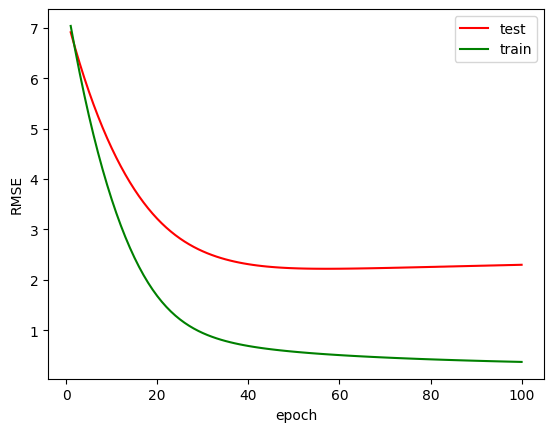

In [12]:
import matplotlib.pyplot as plt

plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.plot(range(1,epochs+1), all_test_loss, color = "red", label='test') 
plt.plot(range(1,epochs+1), all_train_loss, color = "green", label='train')
plt.legend()


# ALS

## Data


In [3]:
data = surprise.Dataset.load_builtin('ml-100k', prompt=False)
col_names = ["userid", "itemid", "rating", "timestamp"]
raw_data = np.array(data.raw_ratings, dtype=int)

raw_data[:,0] -= 1 # user_id range : [0,942]
raw_data[:,1] -= 1 # item_id range : [0,1681]

n_user = np.unique(raw_data[:, 0]).shape[0]
n_item = np.unique(raw_data[:, 1]).shape[0]

shape = (n_user, n_item)
rating_matrix = np.ndarray(shape, dtype=int)

for user_id, movie_id, *etc in raw_data:
    rating_matrix[user_id][movie_id] = 1 # interaction

## Model

In [12]:
class ALS():
    def __init__(self, rating_df, n_factor, reg_param, epochs):
        self.rating_df = rating_df
        self.n_user, self.n_item = rating_df.shape
        self.n_factor = n_factor
        self.reg_param = reg_param
        self.epochs = epochs

    def fit(self):
        self.user = np.random.normal(size=(self.n_user, self.n_factor))
        self.item = np.random.normal(size=(self.n_item, self.n_factor))

        for epoch in tqdm(range(self.epochs)):
            for i, R_i in enumerate(self.rating_df):
                self.user[i] = self.user_latent(i, R_i)
                self.user_error = self.cost()
                
            for j, R_j in tqdm(enumerate(self.rating_df.T)):
                self.item[j] = self.item_latent(j, R_j)
                self.item_error = self.cost()
            
            cost = self.cost()
            print(f'EPOCH : {epoch} | Cost : {cost}')

    def cost(self):
        x_i, y_i = self.rating_df.nonzero()
        cost = 0
        for x, y in zip(x_i, y_i):
            cost += pow(self.rating_df[x,y] - self.get_pred(x,y), 2)
        
        return np.sqrt(cost/len(x_i))
    
    def user_latent(self, i, R_i):
        du = np.linalg.solve(self.item.T@(np.diag(R_i)@self.item) + self.reg_param*(np.eye(self.n_factor)), (self.item.T@(np.diag(R_i)@self.rating_df[i].T))).T
        return du
    
    def item_latent(self, j, R_j):
        di = np.linalg.solve(self.user.T@(np.diag(R_j)@self.user) + self.reg_param*(np.eye(self.n_factor)), self.user.T@(np.diag(R_j)@self.rating_df[:,j].T))
        return di
    
    def get_pred(self, i, j):
        return self.user[i, :]@self.item[j, :].T

    def get_complete_matrix(self):
        return self.user@self.item.T


## train

In [15]:
#parameters
n_factor = 50
reg_param = 0.01
epochs = 3

In [ ]:
model = ALS(rating_matrix, n_factor, reg_param, epochs)
model.fit()
print(model.get_complete_matrix())